In [147]:
# Import libraries and set desired options
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix,coo_matrix
from scipy.sparse import hstack
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

We will be solving the intruder detection problem analyzing his behavior on the Internet. It is a complicated and interesting problem combining the data analysis and behavioral psychology.

For example: Yandex solves the mailbox intruder detection problem based on the user's behavior patterns. In a nutshell, intruder's behaviour pattern might differ from the owner's one: 
- the breaker might not delete emails right after they are read, as the mailbox owner might do
- the intruder might mark emails and even move the cursor differently
- etc.

So the intruder could be detected and thrown out from the mailbox proposing the owner to be authentificated via SMS-code.
This pilot project is described in the Habrahabr article.

Similar things are being developed in Google Analytics and described in scientific researches. You can find more on this topic by searching "Traversal Pattern Mining" and "Sequential Pattern Mining".

In this competition we are going to solve a similar problem: our algorithm is supposed to analyze the sequence of websites consequently visited by a particular person and to predict whether this person is Alice or an intruder (someone else). As a metric we will use [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). We will reveal who Alice is at the end of the course.

###  Data Downloading and Transformation
First, read the training and test sets. 

In [110]:
# Read the training and test data sets
times = ['time%s' % x for x in range(1,11)]

train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


The training data set contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, possesses value of 1 for Alice's sessions, and 0 for the other users' sessions
    
User sessions are chosen in the way they are not longer than half an hour or/and contain more than ten websites. I.e. a session is considered as ended either if a user has visited ten websites or if a session has lasted over thirty minutes.

There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks like:

In [111]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [112]:
# Answer
print(test_df.shape, train_df.shape)

(82797, 20) (253561, 21)


In [113]:
# Our target variable
y_train = train_df['target'].values

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

For the very basic model, we will use only the visited websites in the session (but we will not take into account timestamp features). The point behind this data selection is: *Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is an Alice's session, and vice versa.*

Let us prepare the data, we will take only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero. Here is how the first rows of the dataframe look like:

Transform data into format which can be fed into `CountVectorizer`.

In [114]:
# small
train_df[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
test_df[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)

In [115]:
!head -3 train_sessions_text.txt

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Fit `CountVectorizer` and trasfrom data with it.

In [116]:
%%time
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
print(X_train.shape, X_test.shape)

(253561, 50000) (82797, 50000)
Wall time: 14.1 s


### Training the first model

So, we have an algorithm and data for it. Let us build our first model, using [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation from ` Sklearn` with default parameters. We will use the first 90% of the data for training (the training data set is sorted by time), and the remaining 10% for validation. Let's write a simple function that returns the quality of the model and then train our first classifier:

In [117]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='lbfgs', max_iter=500).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [13]:
X_train.shape, y_train.shape

((253561, 50000), (253561,))

In [14]:
%%time
# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9132501485442661
Wall time: 15.5 s


The first model demonstrated the quality  of 0.9133 on the validation set. Let's take it as the first baseline and starting point. To make a prediction on the test data set  we need to train the model again on the entire training data set (until this moment, our model used only part of the data for training), which will increase its generalizing ability:

In [15]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [16]:
# Train the model on the whole training data set
# Use random_state=17 for reproducibility
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='lbfgs', max_iter=500).fit(X_train, y_train)

# Make a prediction for test data set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

### Making new features 

In [92]:
from datetime import datetime

In [125]:
train_times = train_df[times[:-1]]
test_times = test_df[times[:-1]]
#in case when we have NaN values on time 10, we will set time1 value thus sessions_durations = 0 
train_times['time10'] = train_df['time10'].fillna(train_df['time1'])
test_times['time10'] = test_df['time10'].fillna(test_df['time1'])

#train_times['time10'] = train_times[times].fillna()
#test_times['time10'] = test_times[times].fillna()

C:\Users\Brux\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Brux\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [129]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

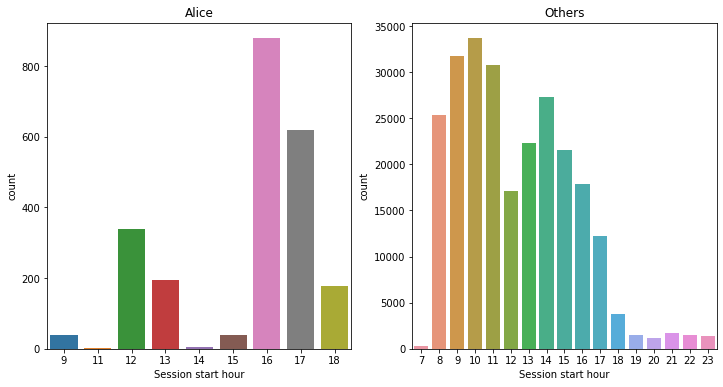

In [130]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

In [139]:
def add_time_features(times, X_sparse):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    midday = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <= 6)).astype('int').values.reshape(-1, 1)
    
 
    sessions_durations = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
    #Because session duration in milliseconds, we should scale it for model better performance  
    scaler = StandardScaler()
    sess_dur_scaled = scaler.fit_transform(sessions_durations.values.reshape(-1, 1))
    
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    X = hstack([X_sparse, morning, midday, evening, night, sess_dur_scaled, day_of_week, month, year_month]).tocsr()
    coo_matrix
    
    return X

In [ ]:
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    X = hstack([X_sparse, morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1)])
    return X

In [140]:
X_train_new = add_time_features(train_times,X_train)
X_test_new = add_time_features(test_times,X_test)

In [141]:
get_auc_lr_valid(X_train_new, y_train)

C:\Users\Brux\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9578502625489713

In [143]:
lr = LogisticRegression(C=1.0, random_state=17, solver='lbfgs', max_iter=1000).fit(X_train_new, y_train)

# Make a prediction for test data set
y_test = lr.predict_proba(X_test_new)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'model2.csv')

### Hyperparameter tuning

In [148]:
time_split = TimeSeriesSplit(n_splits=10)
c_values = np.logspace(-2, 2, 20)

best_lr = GridSearchCV(estimator=lr, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
best_lr.fit(X_train_new, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 46.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+

In [152]:
lr = LogisticRegression(C=best_lr.best_params_['C'], random_state=17, solver='lbfgs', max_iter=1000).fit(X_train_new, y_train)

# Make a prediction for test data set
y_test = lr.predict_proba(X_test_new)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'model3.csv')